# 2. Text Classification 

In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.font_manager import FontProperties
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## 2.1 TFIDF + Random Forest/ SVM/ Logistic Regression

In [5]:
# Load the data
data = pd.read_csv('../filtered-labeled-data/classed_review.csv')

# Only use labeled data
labeled_data = data.dropna(subset=['class'])
X = labeled_data['text']
y = labeled_data['class']

# Split into training and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english', max_features=10000)

# Define the pipeline for each classifier
pipe_rf = Pipeline([
    ('tfidf', tfidf),
    ('clf', RandomForestClassifier(random_state=42))
])

pipe_svm = Pipeline([
    ('tfidf', tfidf),
    ('clf', SVC(random_state=42))
])

pipe_lr = Pipeline([
    ('tfidf', tfidf),
    ('clf', LogisticRegression(random_state=42))
])

# Define hyperparameter grids
param_grid_rf = {
    'clf__n_estimators': [100, 200, 300, 400],
    'clf__max_depth': [10, 20, 40, 80, 100, 120],
    'clf__min_samples_leaf': [1, 2, 4]
}

param_grid_svm = {
    'clf__C': [0.1, 1, 10, 100],
    'clf__kernel': ['linear', 'rbf', 'poly'],
    'clf__gamma': ['scale', 'auto']
}

param_grid_lr = {
    'clf__C': [0.1, 0.5, 1, 2, 5, 10, 20],
    'clf__max_iter': [10, 20, 50, 100, 200],
    'clf__solver': ['sag', 'saga', 'lbfgs', 'newton-cg']
}

# Define scorers
scorers = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted', zero_division=0),
    'recall': make_scorer(recall_score, average='weighted', zero_division=0),
    'f1_score': make_scorer(f1_score, average='weighted', zero_division=0)
}

# Set up GridSearchCV for each classifier
kf = KFold(n_splits=5, shuffle=True, random_state=42)
grid_rf = GridSearchCV(pipe_rf, param_grid_rf, cv=kf, scoring=scorers, refit='f1_score')
grid_svm = GridSearchCV(pipe_svm, param_grid_svm, cv=kf, scoring=scorers, refit='f1_score')
grid_lr = GridSearchCV(pipe_lr, param_grid_lr, cv=kf, scoring=scorers, refit='f1_score')

# Fit the models
grid_rf.fit(X_train, y_train)
grid_svm.fit(X_train, y_train)
grid_lr.fit(X_train, y_train)

# Function to print formatted results for both training and test sets
def print_results(name, grid, X_train, y_train, X_test, y_test):
    print(f"\n{name} Results:")
    print("Cross-validation Results:")
    print(f"  Best Score (F1): {grid.best_score_:.4f}")
    print(f"  Best Parameters: {grid.best_params_}")
    print("  Cross-validation Performance Metrics:")
    print(f"    Accuracy: {grid.cv_results_['mean_test_accuracy'][grid.best_index_]:.4f}")
    print(f"    Precision: {grid.cv_results_['mean_test_precision'][grid.best_index_]:.4f}")
    print(f"    Recall: {grid.cv_results_['mean_test_recall'][grid.best_index_]:.4f}")
    print(f"    F1 Score: {grid.cv_results_['mean_test_f1_score'][grid.best_index_]:.4f}")
    
    # Calculate and print test set performance
    y_pred_test = grid.predict(X_test)
    print("\nTest Set Performance:")
    print(f"    Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
    print(f"    Precision: {precision_score(y_test, y_pred_test, average='weighted', zero_division=0):.4f}")
    print(f"    Recall: {recall_score(y_test, y_pred_test, average='weighted', zero_division=0):.4f}")
    print(f"    F1 Score: {f1_score(y_test, y_pred_test, average='weighted', zero_division=0):.4f}")

# Print results for each model
print_results("Random Forest", grid_rf, X_train, y_train, X_test, y_test)
print_results("SVM", grid_svm, X_train, y_train, X_test, y_test)
print_results("Logistic Regression", grid_lr, X_train, y_train, X_test, y_test)


Random Forest Results:
Cross-validation Results:
  Best Score (F1): 0.8390
  Best Parameters: {'clf__max_depth': 100, 'clf__min_samples_leaf': 1, 'clf__n_estimators': 400}
  Cross-validation Performance Metrics:
    Accuracy: 0.8403
    Precision: 0.8447
    Recall: 0.8403
    F1 Score: 0.8390

Test Set Performance:
    Accuracy: 0.8154
    Precision: 0.8196
    Recall: 0.8154
    F1 Score: 0.8150

SVM Results:
Cross-validation Results:
  Best Score (F1): 0.8536
  Best Parameters: {'clf__C': 1, 'clf__gamma': 'scale', 'clf__kernel': 'linear'}
  Cross-validation Performance Metrics:
    Accuracy: 0.8542
    Precision: 0.8539
    Recall: 0.8542
    F1 Score: 0.8536

Test Set Performance:
    Accuracy: 0.8615
    Precision: 0.8618
    Recall: 0.8615
    F1 Score: 0.8614

Logistic Regression Results:
Cross-validation Results:
  Best Score (F1): 0.8456
  Best Parameters: {'clf__C': 10, 'clf__max_iter': 20, 'clf__solver': 'lbfgs'}
  Cross-validation Performance Metrics:
    Accuracy: 0.8464


## 2.2 Bert

In [1]:
# Load and prepare data
data_path = '../filtered-labeled-data/classed_review.csv'
data = pd.read_csv(data_path)
filtered_data = data.dropna(subset=['class'])
label_mapping = {-1: 0, 1: 1, 9: 2}
filtered_data['class'] = filtered_data['class'].map(label_mapping)

# Split into training and test sets (80-20 split)
train_data, test_data = train_test_split(
    filtered_data, test_size=0.2, random_state=42, stratify=filtered_data['class']
)

def encode_data(tokenizer, data):
    tokens = tokenizer.batch_encode_plus(
        data['text'].tolist(),
        max_length=256,
        padding='max_length',
        truncation=True,
        return_tensors="pt"
    )
    return tokens['input_ids'], tokens['attention_mask'], torch.tensor(data['class'].values)

def evaluate(model, dataloader, device):
    model.eval()
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch in dataloader:
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            outputs = model(b_input_ids, attention_mask=b_input_mask)
            predictions = torch.argmax(outputs.logits, dim=-1)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(b_labels.cpu().numpy())
    
    return (
        accuracy_score(all_labels, all_predictions),
        precision_score(all_labels, all_predictions, average='weighted'),
        recall_score(all_labels, all_predictions, average='weighted'),
        f1_score(all_labels, all_predictions, average='weighted')
    )

def print_results(cv_results, test_results):
    print("\nBERT Model Results:")
    print("Cross-validation Results:")
    print(f"  Best Score (F1): {np.mean([x[3] for x in cv_results]):.4f}")
    print("  Cross-validation Performance Metrics:")
    print(f"    Accuracy: {np.mean([x[0] for x in cv_results]):.4f}")
    print(f"    Precision: {np.mean([x[1] for x in cv_results]):.4f}")
    print(f"    Recall: {np.mean([x[2] for x in cv_results]):.4f}")
    print(f"    F1 Score: {np.mean([x[3] for x in cv_results]):.4f}")
    
    print("\nTest Set Performance:")
    print(f"    Accuracy: {test_results[0]:.4f}")
    print(f"    Precision: {test_results[1]:.4f}")
    print(f"    Recall: {test_results[2]:.4f}")
    print(f"    F1 Score: {test_results[3]:.4f}")

# Initialize model and tokenizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3).to(device)

# Prepare test data
test_inputs, test_masks, test_labels = encode_data(tokenizer, test_data)
test_dataset = TensorDataset(test_inputs, test_masks, test_labels)
test_dataloader = DataLoader(test_dataset, batch_size=16)

# K-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = []

for train_idx, val_idx in kf.split(train_data):
    # Prepare data for this fold
    fold_train_data = train_data.iloc[train_idx]
    fold_val_data = train_data.iloc[val_idx]
    
    train_inputs, train_masks, train_labels = encode_data(tokenizer, fold_train_data)
    val_inputs, val_masks, val_labels = encode_data(tokenizer, fold_val_data)
    
    train_dataset = TensorDataset(train_inputs, train_masks, train_labels)
    train_dataloader = DataLoader(train_dataset, batch_size=16)
    val_dataset = TensorDataset(val_inputs, val_masks, val_labels)
    val_dataloader = DataLoader(val_dataset, batch_size=16)
    
    # Training
    optimizer = AdamW(model.parameters(), lr=2e-5)
    model.train()
    
    for epoch in range(4):
        for batch in train_dataloader:
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            
            model.zero_grad()
            outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
    
    # Evaluate on validation set
    cv_results.append(evaluate(model, val_dataloader, device))

# Final evaluation on test set
test_results = evaluate(model, test_dataloader, device)

# Print results in the same format as the previous code
print_results(cv_results, test_results)

/var/folders/nv/7st69fc94wlfl60y57qczy0c0000gn/T/ipykernel_29439/2550997089.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['class'] = filtered_data['class'].map(label_mapping)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/zhaoqianxue/anaconda3/lib/python3.11/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_depreca


BERT Model Results:
Cross-validation Results:
  Best Score (F1): 0.9722
  Cross-validation Performance Metrics:
    Accuracy: 0.9723
    Precision: 0.9728
    Recall: 0.9723
    F1 Score: 0.9722

Test Set Performance:
    Accuracy: 0.8523
    Precision: 0.8620
    Recall: 0.8523
    F1 Score: 0.8527


## 2.3 Classifiers Plot

/var/folders/nv/7st69fc94wlfl60y57qczy0c0000gn/T/ipykernel_33038/42650378.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  colorbar.set_ticklabels([f'{x:.3f}' for x in colorbar.get_ticks()])
/var/folders/nv/7st69fc94wlfl60y57qczy0c0000gn/T/ipykernel_33038/42650378.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  colorbar.set_ticklabels([f'{x:.3f}' for x in colorbar.get_ticks()])
/var/folders/nv/7st69fc94wlfl60y57qczy0c0000gn/T/ipykernel_33038/42650378.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  colorbar.set_ticklabels([f'{x:.3f}' for x in colorbar.get_ticks()])
/var/folders/nv/7st69fc94wlfl60y57qczy0c0000gn/T/ipykernel_33038/42650378.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  colorbar.set_ticklabels([f'{x:.3f}' for x in colorbar.get_ticks()])


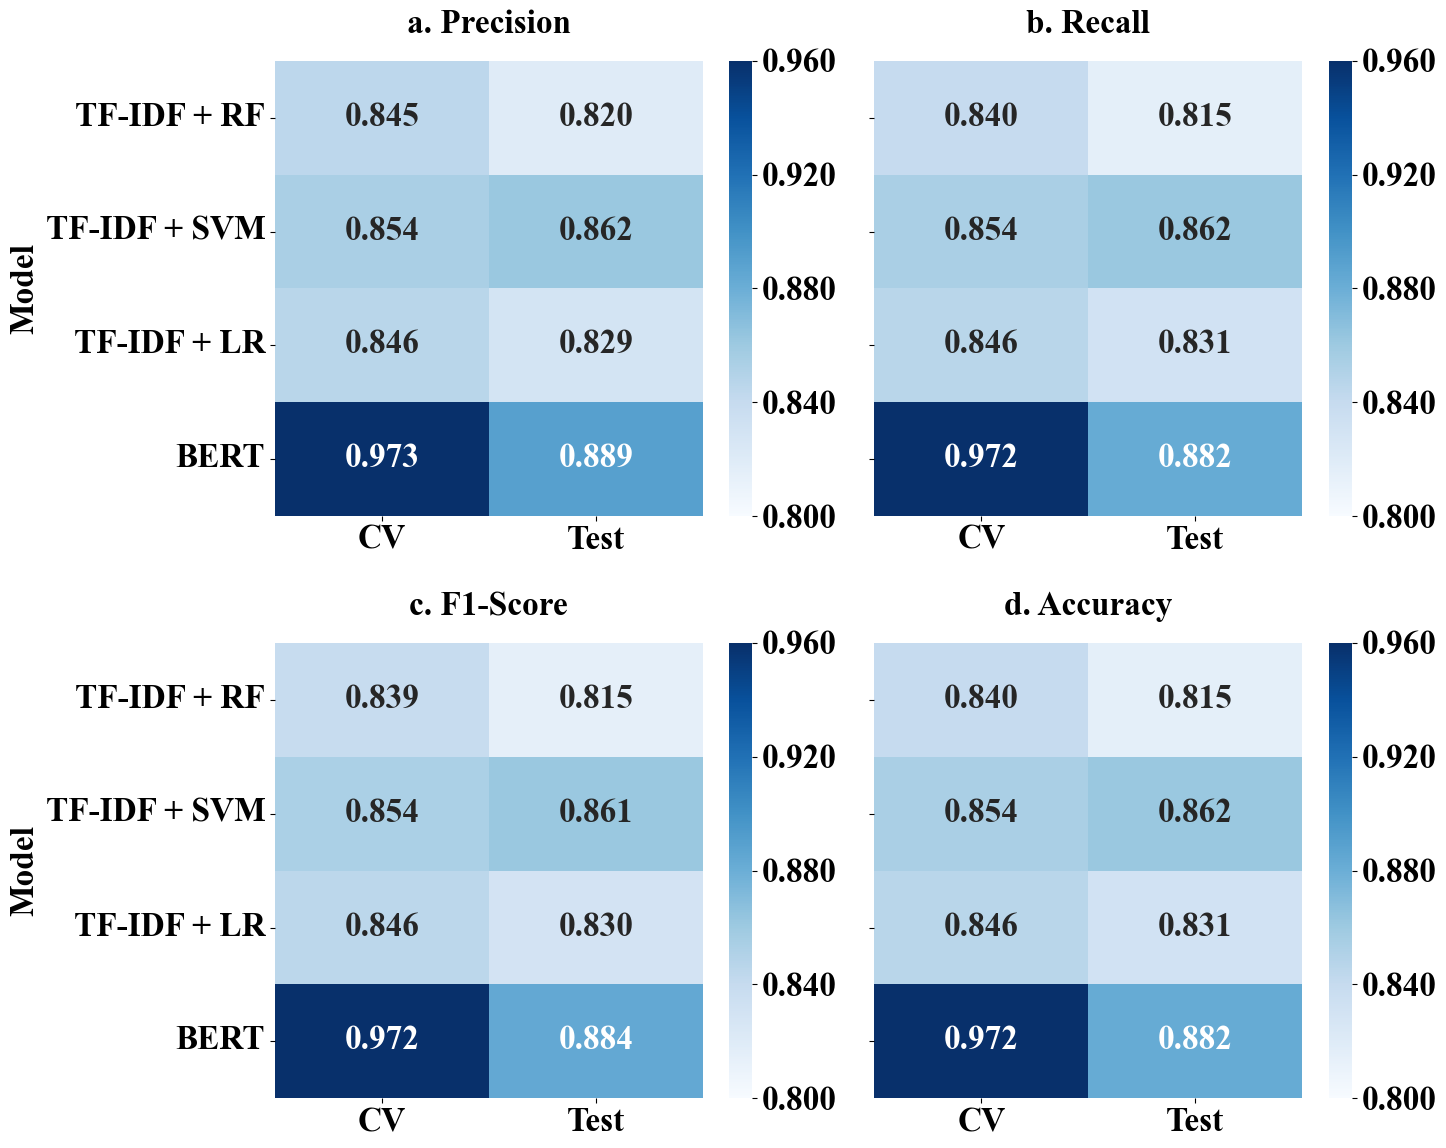

In [3]:
# Set global font properties
font_props = FontProperties(family='Times New Roman', weight='bold')
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.size'] = 24

# Create DataFrames for each metric with BERT included
precision_data = pd.DataFrame({
    'Model': ['TF-IDF + RF', 'TF-IDF + SVM', 'TF-IDF + LR', 'BERT'],
    'CV': [0.8447, 0.8539, 0.8463, 0.9728],
    'Test': [0.8196, 0.8618, 0.8293, 0.8895]
})

recall_data = pd.DataFrame({
    'Model': ['TF-IDF + RF', 'TF-IDF + SVM', 'TF-IDF + LR', 'BERT'],
    'CV': [0.8403, 0.8542, 0.8464, 0.9723],
    'Test': [0.8154, 0.8615, 0.8308, 0.8821]
})

f1_data = pd.DataFrame({
    'Model': ['TF-IDF + RF', 'TF-IDF + SVM', 'TF-IDF + LR', 'BERT'],
    'CV': [0.8390, 0.8536, 0.8456, 0.9722],
    'Test': [0.8150, 0.8614, 0.8296, 0.8842]
})

accuracy_data = pd.DataFrame({
    'Model': ['TF-IDF + RF', 'TF-IDF + SVM', 'TF-IDF + LR', 'BERT'],
    'CV': [0.8403, 0.8542, 0.8464, 0.9723],
    'Test': [0.8154, 0.8615, 0.8308, 0.8821]
})

# Create figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

def create_heatmap(data, ax, title, vmin=0.80, vmax=0.96):  # Adjusted vmax to accommodate BERT's higher values
    # Create the heatmap
    heatmap = sns.heatmap(data.set_index('Model'), annot=True, cmap='Blues', 
                         fmt='.3f', vmin=vmin, vmax=vmax, ax=ax, cbar=True,
                         annot_kws={'size': 24, 'font': font_props})
    
    # Format colorbar
    colorbar = heatmap.collections[0].colorbar
    colorbar.set_ticks(ticker.LinearLocator(5))
    colorbar.set_ticklabels([f'{x:.3f}' for x in colorbar.get_ticks()])
    colorbar.ax.tick_params(labelsize=24)
    for label in colorbar.ax.get_yticklabels():
        label.set_font_properties(font_props)

    # Configure y-axis labels
    if ax in [axes[0,0], axes[1,0]]:
        ax.set_ylabel('Model', fontsize=24, font=font_props)
        ax.tick_params(axis='y', which='major', labelsize=24)
        labels = ax.get_yticklabels()
        ax.set_yticklabels(labels, rotation=0, font=font_props)
    else:
        ax.set_ylabel('')
        ax.set_yticklabels([])

    # Configure x-axis labels
    ax.tick_params(axis='x', which='major', labelsize=24)
    for label in ax.get_xticklabels():
        label.set_font_properties(font_props)

    # Set title
    ax.set_title(title, pad=20, font=font_props)

# Create heatmaps
create_heatmap(precision_data, axes[0,0], 'a. Precision')
create_heatmap(recall_data, axes[0,1], 'b. Recall')
create_heatmap(f1_data, axes[1,0], 'c. F1-Score')
create_heatmap(accuracy_data, axes[1,1], 'd. Accuracy')

plt.tight_layout()
plt.show()

## 2.4 Classification

In [4]:
# Load the datasets
data_path = '../filtered-labeled-data/classed_review.csv'
unlabeled_data_path = '../filtered-labeled-data/unlabeled_review.csv'
data = pd.read_csv(data_path)
unlabeled_data = pd.read_csv(unlabeled_data_path)

# Separate the data with non-null and null class values
train_data = data.dropna(subset=['class'])
predict_data = unlabeled_data  # Use the unlabeled data for prediction

# Map labels for training
label_mapping = {-1: 0, 1: 1, 9: 2}  # Mapping old labels to new indices
train_data['class'] = train_data['class'].map(label_mapping)

# Function to tokenize data
def encode_data(tokenizer, texts):
    tokens = tokenizer.batch_encode_plus(
        texts,
        max_length=256,
        padding='max_length',
        truncation=True,
        return_tensors="pt"
    )
    return tokens['input_ids'], tokens['attention_mask']

# Initialize tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# Prepare training data
train_inputs, train_masks = encode_data(tokenizer, train_data['text'].tolist())
train_labels = torch.tensor(train_data['class'].values)

# DataLoader setup
train_dataset = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(train_dataset, batch_size=16)

# Training setup
optimizer = AdamW(model.parameters(), lr=2e-5)

# Train the model
model.train()
for epoch in range(4):  # Adjust the number of epochs if necessary
    for batch in train_dataloader:
        batch = tuple(t.to(model.device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        model.zero_grad()
        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

# Predict classes for the unlabeled data
predict_inputs, predict_masks = encode_data(tokenizer, predict_data['text'].tolist())
predict_dataset = TensorDataset(predict_inputs, predict_masks)
predict_dataloader = DataLoader(predict_dataset, batch_size=16)

# Prediction
model.eval()
predictions = []
for batch in predict_dataloader:
    batch = tuple(t.to(model.device) for t in batch)
    b_input_ids, b_input_mask = batch
    with torch.no_grad():
        outputs = model(b_input_ids, attention_mask=b_input_mask)
    logits = outputs.logits
    pred = torch.argmax(logits, dim=-1)
    predictions.extend(pred.cpu().numpy())

# Reverse map labels and update the dataframe
reverse_label_mapping = {0: -1, 1: 1, 2: 9}
predictions = [reverse_label_mapping[p] for p in predictions]
predict_data['class'] = predictions

# Save the new dataframe
predict_data.to_csv('../filtered-labeled-data/classed_review_2018.csv', index=False)

/var/folders/nv/7st69fc94wlfl60y57qczy0c0000gn/T/ipykernel_61706/3789513804.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['class'] = train_data['class'].map(label_mapping)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/zhaoqianxue/anaconda3/lib/python3.11/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_w

In [5]:
class_counts = predict_data['class'].value_counts()
print(class_counts)

 9    189725
-1     57089
 1     43304
Name: class, dtype: int64


In [6]:
predict_data.head()

,user_id,name,time,rating,text,pics,resp,gmap_id,keywords_mentioned,mentioned_keywords,class
0,1.171145e+20,Laura Gilinsky,2021-08-18 17:18:32.860,5.0,Elena kindly talked me through the custom opti...,NaN,NaN,0x8793f3c9c4a6066d:0x5636690d1815fa0b,True,['mask'],9
1,1.121227e+20,Patty Damme,2018-01-05 16:51:25.395,4.0,"It's quick in and out usually, the sell alcoho...",NaN,NaN,0x8796681daaba37f1:0x45d0ffe31b28ae63,True,['alcohol'],1
2,1.021695e+20,Megan Lynn,2021-05-27 03:20:33.316,1.0,Still forcing masks after the mandate has ended,NaN,NaN,0x87938b9da361a3d9:0x577157078adb3359,True,['mask'],9
3,1.151289e+20,Susan “SuzyQsLion” Woolery,2018-02-24 04:27:23.868,5.0,"Carries cold drinks, fountain drinks, coffee, ...",NaN,NaN,0x8776e8324b8c3ecf:0xdb935c6665556259,True,['alcohol'],1
4,1.142903e+20,Courtney Scholl,2021-08-28 14:37:46.157,2.0,Update 8/27: We have a new mask mandate in Li...,NaN,"{'time': 1617157609725, 'text': 'Update: As wr...",0x8796960819abf859:0x6e4e236c8ff7317f,True,['mask'],9
